In [12]:
from seedtools import load_seed
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

## <center> 1. Data Loading <center/>

In [28]:
seed =  load_seed("WineQT.csv").data.drop(columns=["Id"])
seed["quality"] =  (seed["quality"] >= 7).astype(int)
df_0 =  seed[seed["quality"] == 0][:150]  # equalizing data 
df_1 =  seed[seed["quality"] == 1][:150]
df =  pd.concat([df_0,df_1])
print("old shape :",seed.shape)
print("New Shape :",df.shape)
df.head(3)

Shape: [1143, 13]
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Id']
Description: predict wine quality 
old shape : (1143, 12)
New Shape : (300, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0


In [7]:
x =  df.drop(columns=["quality"]).values
y =  df["quality"].values 
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size=0.2,random_state=42)


## <center> 2. EDA and analysis <center/>

Text(0.5, 1.0, 'after labelling')

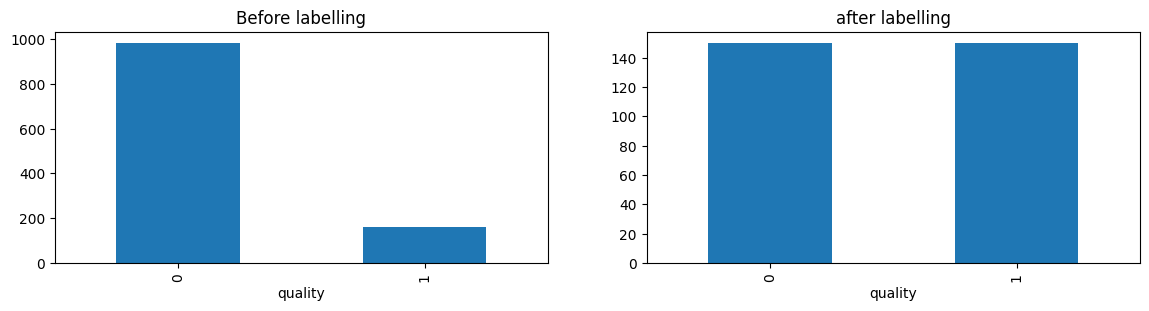

In [3]:

plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
seed["quality"].value_counts().plot(kind="bar")
plt.title("Before labelling")

plt.subplot(1,2,2)
df["quality"].value_counts().plot(kind="bar")
plt.title("after labelling")

In [4]:
df.corr()["quality"]

fixed acidity           0.386453
volatile acidity       -0.513525
citric acid             0.443934
residual sugar          0.194658
chlorides              -0.170729
free sulfur dioxide    -0.052104
total sulfur dioxide   -0.284445
density                -0.127129
pH                     -0.187160
sulphates               0.197747
alcohol                 0.672862
quality                 1.000000
Name: quality, dtype: float64

<Axes: xlabel='pH', ylabel='alcohol'>

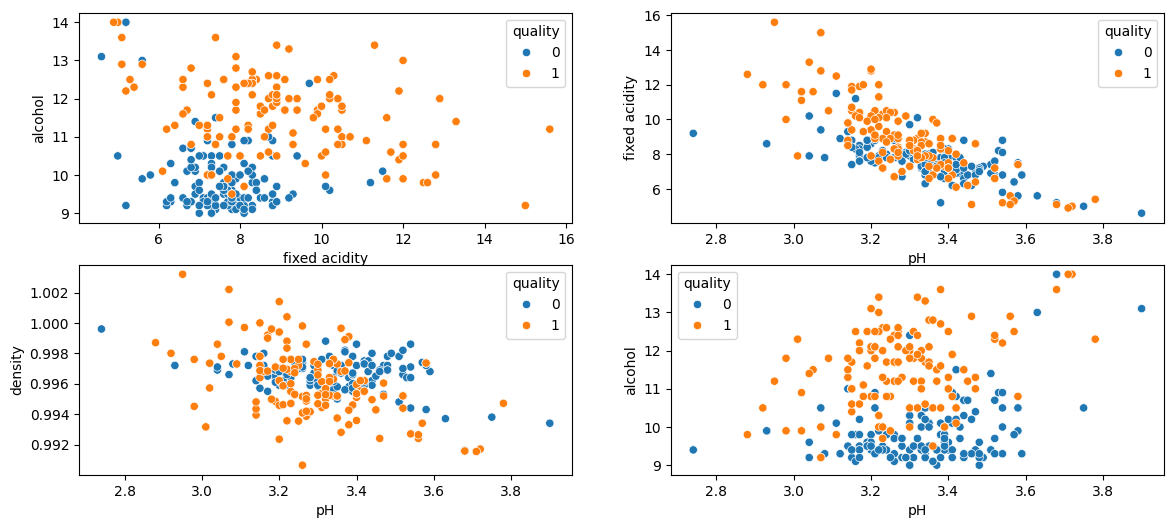

In [5]:
plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
sns.scatterplot(df,x=df["fixed acidity"],y=df["alcohol"],hue="quality")

plt.subplot(2,2,2)
sns.scatterplot(df,x="pH",y="fixed acidity",hue="quality")



plt.subplot(2,2,3)
sns.scatterplot(df,x="pH",y="density",hue="quality")



plt.subplot(2,2,4)
sns.scatterplot(df,x="pH",y="alcohol",hue="quality")

<Axes: xlabel='sulphates', ylabel='Density'>

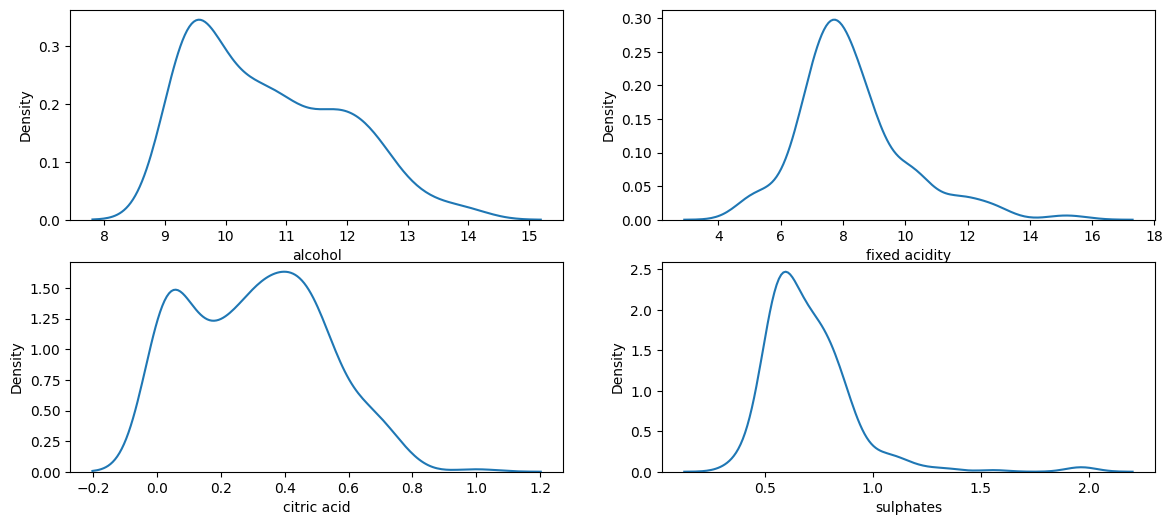

In [27]:

plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
sns.kdeplot(df["alcohol"])


plt.subplot(2,2,2)
sns.kdeplot(df["fixed acidity"])

plt.subplot(2,2,3)
sns.kdeplot(df["citric acid"])

plt.subplot(2,2,4)
sns.kdeplot(df["sulphates"])

## <center> 3. Model Building <center/>

**why not standard scaler ?** <br />
(standard scaler is giving low results ,around 85-87% )

In [6]:
pca=  PCA()
rf =  RandomForestClassifier(max_depth=5,n_estimators=200)
xgb =  XGBClassifier()

Kind of custom hyperparameter tuning 

In [8]:

def score_model(pca_c=3,model_name="rf"):
    model =  rf if model_name == "rf" else xgb
    pca.n_components =  pca_c
    
    models = []
    models.append(("pca",pca))
    models.append((model_name,model))
    
    pipe=  Pipeline(models)
    pipe.fit(x_train,y_train)
    score = pipe.score(x_test,y_test)
    return (score,pipe)
    
    

### WHO is better XGB OR RF ?

In [9]:
# kind of custom grid search cv 
for c in range(1,12):
    for model in ["rf","xgb"]:
        score,_ =  score_model(pca_c=c,model_name=model)
        print(f"C : {c} || MODEL : {model} || SCORE : {round(score,2)}  ")


C : 1 || MODEL : rf || SCORE : 0.7  
C : 1 || MODEL : xgb || SCORE : 0.7  
C : 2 || MODEL : rf || SCORE : 0.73  
C : 2 || MODEL : xgb || SCORE : 0.72  
C : 3 || MODEL : rf || SCORE : 0.85  
C : 3 || MODEL : xgb || SCORE : 0.92  
C : 4 || MODEL : rf || SCORE : 0.82  
C : 4 || MODEL : xgb || SCORE : 0.92  
C : 5 || MODEL : rf || SCORE : 0.87  
C : 5 || MODEL : xgb || SCORE : 0.97  
C : 6 || MODEL : rf || SCORE : 0.88  
C : 6 || MODEL : xgb || SCORE : 0.95  
C : 7 || MODEL : rf || SCORE : 0.88  
C : 7 || MODEL : xgb || SCORE : 0.87  
C : 8 || MODEL : rf || SCORE : 0.87  
C : 8 || MODEL : xgb || SCORE : 0.9  
C : 9 || MODEL : rf || SCORE : 0.88  
C : 9 || MODEL : xgb || SCORE : 0.87  
C : 10 || MODEL : rf || SCORE : 0.9  
C : 10 || MODEL : xgb || SCORE : 0.92  
C : 11 || MODEL : rf || SCORE : 0.88  
C : 11 || MODEL : xgb || SCORE : 0.88  


our best model is "XGB" with n_components: 5  <br />
accuracy of 97%

**Our best model**

In [10]:
score, pipe = score_model(pca_c=5,model_name="xgb")
score

0.9666666666666667

**Below is which feature is able to explain most of the variance**

In [13]:
print(pipe.steps[0][1].explained_variance_ratio_.tolist())
print("99.9% var is explained within 5 components :",np.sum(pipe.steps[0][1].explained_variance_ratio_[:5] *100))

[0.9664892281476524, 0.02960537059830846, 0.0021153560074296733, 0.0011437639211403989, 0.000582051484395819]
99.9% var is explained within 5 components : 99.99357701589267


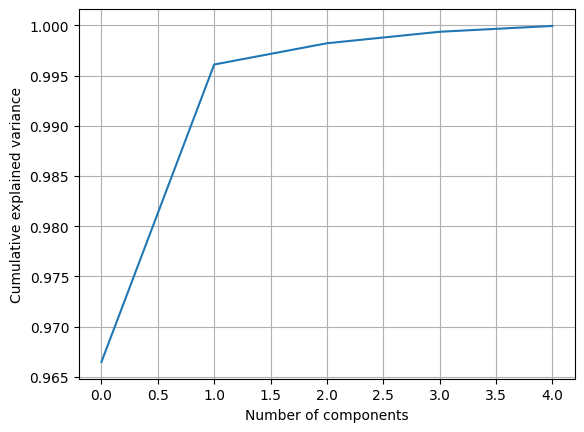

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)

## <center> 5. Evaluating Metrics  <center/>

In [15]:
pred =   pipe.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.97      0.97      0.97        31

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



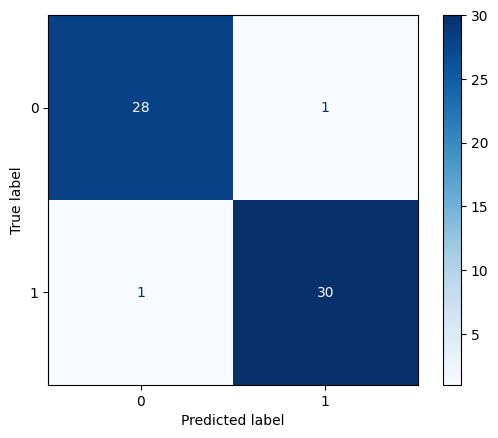

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues')